## Setup

In [1]:
import numpy as np
import os
import io
import warnings


from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate,cross_val_predict,cross_val_score,GridSearchCV
from pprint import pprint
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#global matplotlib settings
mpl.rc('figure',figsize=(8,6))
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
# suppress warnings
def warn(*args,**kwargs):
    pass
warnings.warn=warn

## Handwritten Digit Classifier

- <b>Perceptron classifier</b> to classify (recognize) given digit images. Since a single perceptron could be only used for binary classificatiom, we consider two classes in the first half. Eventually, we extend it to a multi-class setting.
- <b>Binary classification problem</b> -> Whether the given digit is a zero or Not.
- Use of the <b>MNIST<b> dataset 
 

### Data Loading & Splitting

In [3]:
X,y=fetch_openml('mnist_784',version=1,return_X_y=True)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
X=X.to_numpy()
y=y.to_numpy()

In [5]:
target_names=np.unique(y)
print(f"Number of samples:{X.shape[0]}")
print(f"Number of features:{X.shape[1]}")
print(f"labels:{target_names}")

Number of samples:70000
Number of features:784
labels:['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


pixels can take values between 0 and 255. We can either use <b>MinMaxScaler<b> or <b>MaxAbsoluteScaler</b>

In [6]:
X=MinMaxScaler().fit_transform(X)
print(f"Minimum:{np.min(X)}, Maximum:{np.max(X)}")

Minimum:0.0, Maximum:1.0


### Data visualization

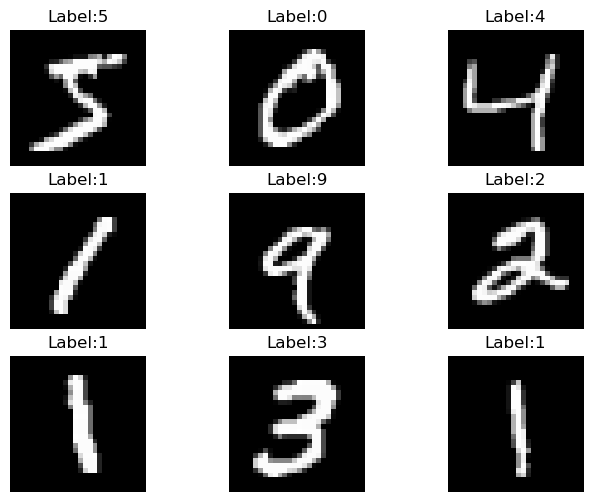

In [7]:
num_images=9
factor=int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
    ax[i,j].set_axis_off()
    

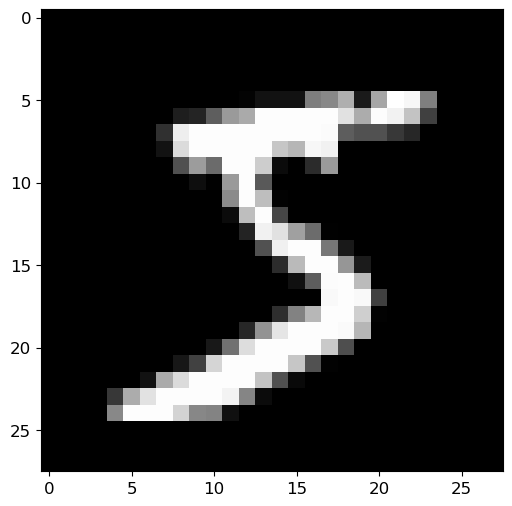

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(X[0].reshape(28,28),cmap='gray')
plt.show()

## Data splitting

In [9]:
# the samples are already shuffled, hence no need of train_Test_split

X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

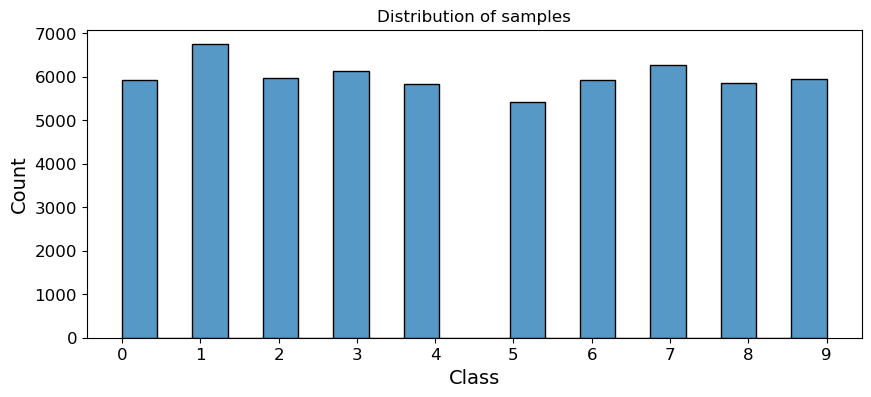

In [10]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),bins=11,binwidth=0.45)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary Classification (0 detector)

#### Modifying Labels
Since the original dataset has 10 classes, we need to modify them to 2. <br>
The label 0 will be changed to 1 & all the others will be changed to -1 <br>
y_train_0 and y_test_0 respectively.

In [11]:
y_train_0=-1*np.ones(len(y_train))
y_test_0=-1*np.ones(len(y_test))

idx_0=np.where(y_train=='0')
y_train_0[idx_0]=1

indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

In [12]:
print(y_train_0)
print(y_test_0)

[-1.  1. -1. ... -1. -1. -1.]
[-1. -1. -1. ... -1. -1. -1.]


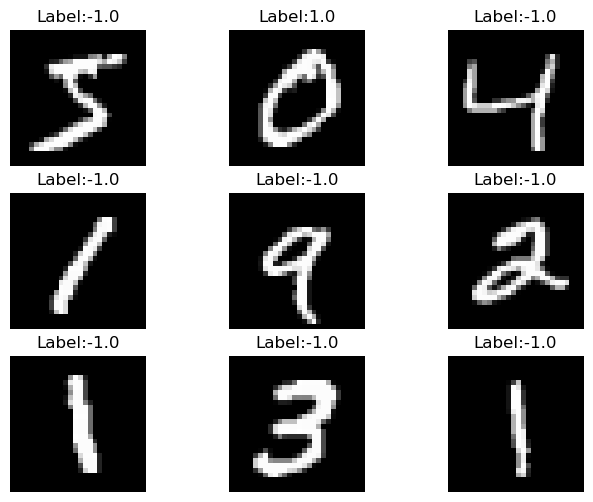

In [13]:
num_images = 9 
factor = np.int8(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
    ax[i,j].set_title('Label:{0}'.format(str(y_train_0[index+j])))
    ax[i,j].set_axis_off()

## Baseline Models

In [14]:

print(f"1:{np.where(y_train_0==1)[0].shape}")
print(f"-1:{np.where(y_train_0==-1)[0].shape}")

1:(5923,)
-1:(54077,)


In [15]:
base_clf=DummyClassifier(strategy="most_frequent")

In [16]:
base_clf.fit(X_train,y_train_0)
print(f"training accuracy:{base_clf.score(X_train,y_train_0)}")
print(f"test accuracy:{base_clf.score(X_test,y_test_0)}")

training accuracy:0.9012833333333333
test accuracy:0.902


The reason is obvious. The model would have predicted 54077 samples by outputting -1 for all the samples. Therefore, the accuracy will be 54077/60000=90.12 <br>
This is why accuracy is not always a good measure

## Perceptron Model

Let us quickly recap various components in the general settings:
1.  **Training data**: (features, label) or $(\mathbf{X}, y)$, where label $y$ is a **discrete** number from a finite set.**Features** in this case are pixel values of an image.
2. **Model :** \begin{eqnarray}
  h_{\mathbf{w}}: y &=& \mathrm{g}(\mathbf{w}^T \mathbf{x}) \\
    &=& \mathrm{g}(w_0 + w_1 x_1 + \ldots + w_m x_m)
\end{eqnarray}
where,
  * $\mathbf{w}$ is a weight vector in $\mathbb{R}^{(m+1)}$ i.e. it has components: $\{w_0, w_1, \ldots, w_m\}$
  * $\mathrm{g}(.)$ is a non-linear activation function given by a signum function:
\begin{equation}
  \mathrm{g}(z) =\left\{
  \begin{array}{@{}ll@{}}
    +1, & \text{if}\ z \ge 0 \\
    -1, & \text{otherwise (i.e. } z < 0)
  \end{array}\right.
\end{equation}
3.**Loss function:**
Let $\widehat{y^{(i)}} \in \{-1, +1\}$ be the prediction from perceptron and $y^{(i)}$ be the actual label for $i$-th example.  The error is
\begin{equation}
  e^{(i)} =\left\{
  \begin{array}{@{}ll@{}}
    0, & \text{if}\ \widehat{y^{(i)}} = y^{(i)} \\
    -\mathbf{w}^T \mathbf{x}^{(i)}y^{(i)}, & \text{otherwise (i.e. }\widehat{y^{(i)}} \neq y^{(i)} )
  \end{array}\right.
\end{equation}

  This can be compactly written as:
\begin{equation}
  e^{(i)} = \mathrm{max}(-\mathbf{w}^T \mathbf{x}^{(i)}y^{(i)}, 0)
          = \mathrm{max}(-h_{\mathbf{w}}(\mathbf{x}^{(i)})y^{(i)}, 0)
\end{equation}
4.**Optimization:**
  * Perceptron learning algorithm
  
  1. Initialize $\mathbf{w}^{(0)} = \mathbf{0}$
  2. For each training example $\left(\mathbf{x}^{(i)}, y^{(i)} \right)$:
    * $\hat{y}^{(i)} = \mathrm{sign}\left(\mathbf{w}^T \mathbf{x}^{(i)}\right)$   [Calculate the output value]
    * $\mathbf{w}^{(t+1)} := \mathbf{w}^{(t)} + \alpha (y^{(i)} - \hat{y}^{(i)})\ \mathbf{x}^{(i)}$  [Update the weights]

  > Linearly separable examples lead to convergence of the algorithm with zero training loss, else it oscillates.

In [17]:
bin_clf=Perceptron(max_iter=1000,random_state=42)
bin_clf.fit(X_train,y_train_0)
print(f"Dimention of Weights w:{bin_clf.coef_.shape}")

Dimention of Weights w:(1, 784)


In [18]:
print('Bias :{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Bias :[-96.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x158d34df0>


In [19]:
y_hat_train_0=bin_clf.predict(X_train)
print('Training Accuracy: ',bin_clf.score(X_train,y_train_0))

Training Accuracy:  0.99185


In [20]:
print('Test accuracy: ',bin_clf.score(X_test,y_test_0))

Test accuracy:  0.9907


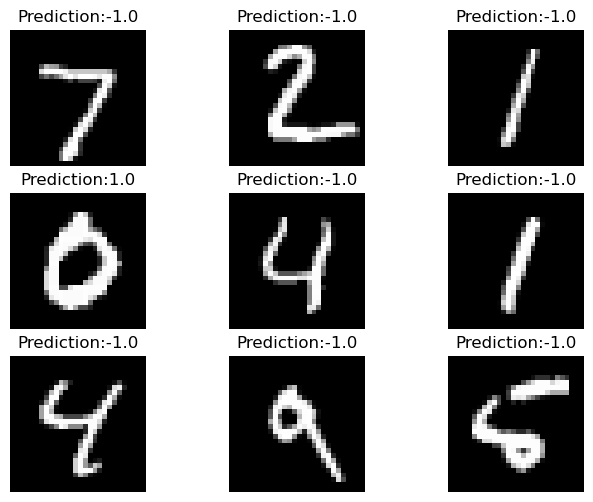

In [21]:
y_hat_test_0 = bin_clf.predict(X_test)
num_images = 9 # Choose a square number
factor = np.int8(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(X_test[index+j].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index+j])))
    ax[i,j].set_axis_off()

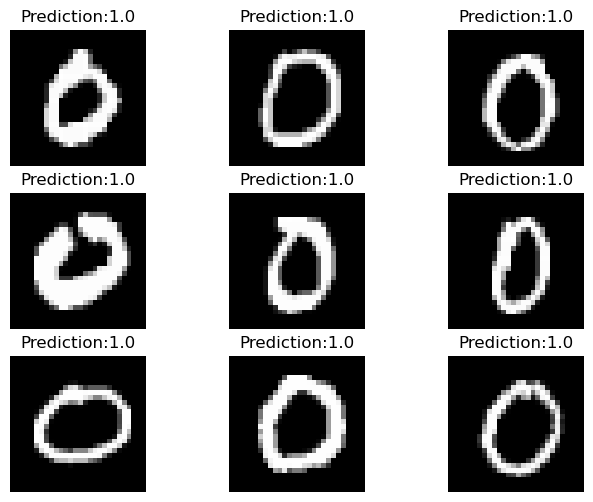

In [22]:
indx_0 = np.where(y_test_0 == 1)
zeroImgs = X_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]
num_images = 9 # Choose a square number
factor = np.int8(np.sqrt(num_images))
fig,ax = plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset = 0 # display "num_images" starting from idx_offset
for i in range(factor):
  index = idx_offset+i*(factor)
  for j in range(factor):
    ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray') # we should not use x_train_with_dummy
    ax[i,j].set_title('Prediction:{0}'.format(str(zeroLabls[index+j])))
    ax[i,j].set_axis_off()

In [23]:
num_misclassified=np.count_nonzero(zeroLabls==-1)
num_correctpred = len(zeroLabls)-num_misclassified
accuracy = num_correctpred/len(zeroLabls)
print(accuracy)

0.9581632653061225


# Better Evalution Metrics

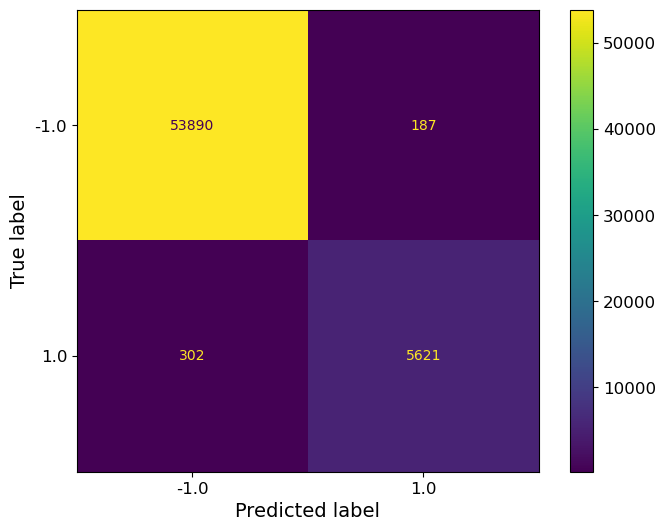

In [24]:
y_hat_train_0 = bin_clf.predict(X_train)
cm_display=ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format=".5g")
plt.show()

### Precision and Recall

$precision=\frac{TP}{TP+FP}$

$recall\ ( sensitivity) =\frac{TP}{TP+FN}$

In [25]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

In [26]:
precision = tp/(tp+fp)
precision

0.9678030303030303

In [27]:
recall = tp/(tp+fn)
recall

0.9490123248353874

In [28]:
accuracy = (tn+tp)/(tn+tp+fn+fp)
accuracy

0.99185

- In general, we would like to know whether the model under consideration with the set hyper-parameters is a good one for a given problem.

### Cross validation

In [29]:
bin_clf = Perceptron(max_iter=1000,random_state=42)
scores= cross_validate(bin_clf, X_train, y_train_0, cv=5,
                       scoring=['precision','recall','f1'],
                       return_estimator=True)
print(scores)

{'fit_time': array([1.22476387, 1.77148604, 2.15067601, 1.83285284, 1.26192784]), 'score_time': array([0.06092596, 0.0505662 , 0.03457808, 0.02977109, 0.02892113]), 'estimator': [Perceptron(random_state=42), Perceptron(random_state=42), Perceptron(random_state=42), Perceptron(random_state=42), Perceptron(random_state=42)], 'test_precision': array([0.92084006, 0.95388557, 0.9255928 , 0.93591906, 0.97511111]), 'test_recall': array([0.96283784, 0.94341216, 0.95527426, 0.93670886, 0.9257384 ]), 'test_f1': array([0.94137077, 0.94861996, 0.94019934, 0.93631379, 0.94978355])}


<b>Note</b>
- The perceptron estimator passed as an argument to the function cross_validate is internally cloned num_fold (cv=5) times and fitted independently on each fold. (you can check this by setting warm_start=True)
- Compute the average and standard deviation of scores for all three metrics on (k=5) folds to measure the generalization!.

In [30]:
print(f"f1:{scores['test_f1'].mean(),scores['test_f1'].std()}")
print(f"precision:{scores['test_precision'].mean(),scores['test_precision'].std()}")
print(f"recall:{scores['test_recall'].mean(),scores['test_recall'].std()}")

f1:(0.9432574804956667, 0.0051472806389300605)
precision:(0.9422697207700608, 0.019955778449769188)
recall:(0.9447943037974683, 0.013159110449310613)


- Let us pick the first estimator returned by the cross-validate function.
- So we can hope that the model might also perform well on test data. Let's check that out..

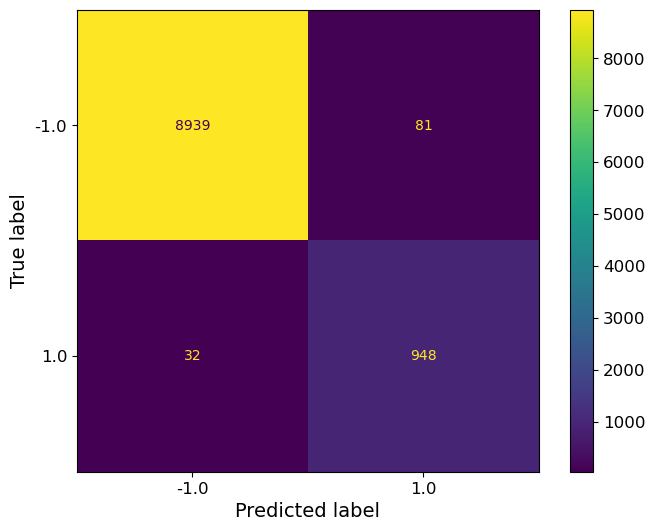

In [31]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_hat_test_0,values_format='.5g') # it return matplotlin plot object

In [32]:
print('Precision %.2f'%precision_score(y_test_0,y_hat_test_0))
print('Recall %.2f'%recall_score(y_test_0,y_hat_test_0))

Precision 0.92
Recall 0.97


 This is good!

## Precision Recall Curve

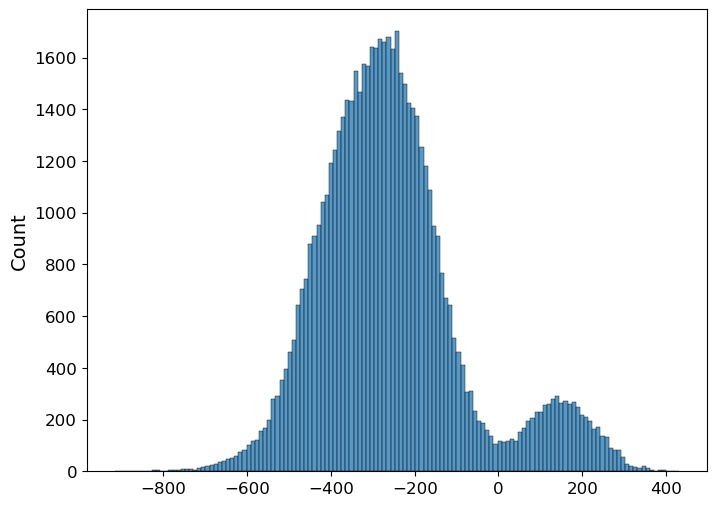

In [34]:
# pass the probabilities to the pr curve and not the class predicitons
bin_clf=Perceptron(random_state=42)
bin_clf.fit(X_train,y_train_0)
y_scores=bin_clf.decision_function(X_train)
sns.histplot(np.sort(y_scores))
plt.show()

the dataset is heavily imbalanced. As presumed, there are many negatives as compared to positives.

In [35]:
precisions,recalls, thresholds=precision_recall_curve(y_train_0,y_scores,pos_label=1)

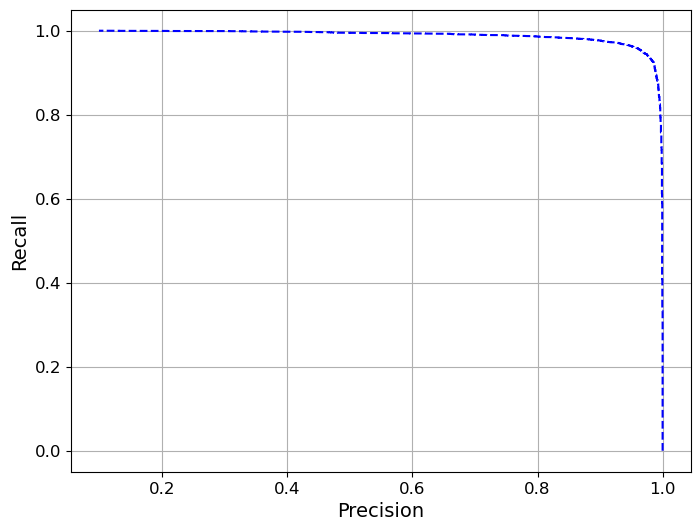

In [36]:
plt.plot(precisions[::-1],recalls[::-1],"b--")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.grid(True)

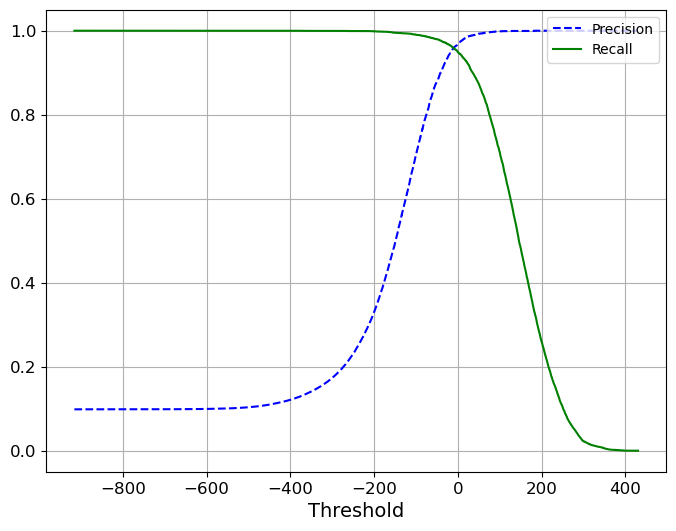

In [37]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

In [38]:
#get the index around threshold zero
idx_th=np.where(np.logical_and(thresholds>0,thresholds<1))
print('precision for zero thereshold:',precisions[idx_th[0][0]])

precision for zero thereshold: 0.9678030303030303


Here is the solution to the question how can we increase the precision of the classifier by compromising the recall. we can make use of the above plot.
Let's see how.

In [39]:
def predict(y_scores):
  y_hat = np.where(y_scores>20,1,-1) # shifted signum function
  return y_hat

In [40]:
y_hat_train_0_thrsh = predict(y_scores)
print(classification_report(y_train_0,y_hat_train_0_thrsh))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      1.00     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## The ROC curve

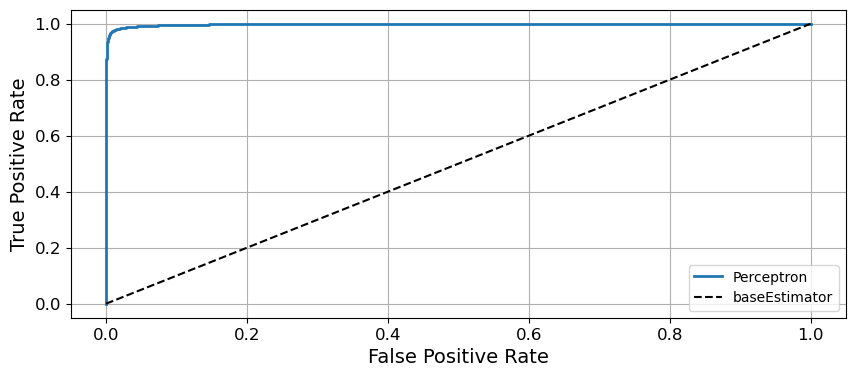

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2,label='Perceptron')
plt.plot([0, 1], [0, 1], 'k--',label='baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

## Warm start vs Cold Start

### Cold Start

If we execute the fit method of bin_clf repeatedly, we get the same score for both training and testing accuracy.

This because every time thefitmethod is called, the model weights are initialized to the same values. Therfore, we obtain the same score.

This is termed as cold start. Let's execute the following cell 4 times and observe the score.m

In [46]:
bin_clf.fit(X_train,y_train_0)
y_hat_train_0 = bin_clf.predict(X_train)
print('Training Accuracy:',bin_clf.score(X_train,y_train_0))
print('Test accuracy: ',bin_clf.score(X_test,y_test_0))

Training Accuracy: 0.99185
Test accuracy:  0.9907


- Setting warm_start=True retains the weight values of the model after max_iter and hence produce different results for each execution.
- Warm starting is useful in many ways.It helps us train the model by initializing the weight values from the previous state.So we can pause the training and resume it whenever we get the resource for computation.
- Of course, it is not required for simple models like perceptron and for a small dataset like MNIST.

In [47]:
bin_clf_warm = Perceptron(max_iter=100,random_state=1729,warm_start=True)


In [49]:
bin_clf_warm.fit(X_train,y_train_0)
print('Training Accuracy:',bin_clf_warm.score(X_train,y_train_0))

Training Accuracy: 0.99215


# MultiClass classifier (One vs All)

- perceptron is a <u>binary classifier</u> However, mnist dataset has 10 classes. How do we extend it to a multi-class problem?
- Solution: combine multiple binary classifiers and devise a suitable scoring metric
- Sklearn does this by counting a number of unique elements(10 in this case) and converting the labels using <b>LabelBinarizer<b> to fit each binary classifier
  

In [50]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import LabelBinarizer


In [51]:
clf=Perceptron(random_state=42)

In [52]:
y_train_ovr=LabelBinarizer().fit_transform(y_train)
for i in range(10):
    print(f"{y_train[i]}:{y_train_ovr[i]}")

5:[0 0 0 0 0 1 0 0 0 0]
0:[1 0 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
9:[0 0 0 0 0 0 0 0 0 1]
2:[0 0 1 0 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
3:[0 0 0 1 0 0 0 0 0 0]
1:[0 1 0 0 0 0 0 0 0 0]
4:[0 0 0 0 1 0 0 0 0 0]


In [54]:
clf.fit(X_train,y_train)

Perceptron(random_state=42)

-  What had actually happened internally was that the API automatically created 10 binary classifiers, converted labels to binary sparse matrix and trained them with the binarized labels!.
-  During the inference time, the input will be passed through all these 10 classifiers and the highest score among the ouput from the classifiers will be considered as the predicted class.
-  Let's see it in action

In [55]:
print(f"Shape of the weight matrix:{clf.coef_.shape} and of the intercept:{clf.intercept_.shape}")

Shape of the weight matrix:(10, 784) and of the intercept:(10,)


- So it is a matrix of size  10×784  where <b>each row represents the weights for a single binary classifier.</b>
- Important difference to note is that there is no signum function associated with the perceptron.

The class of a perceptron that outputs the maximum score for the input sample is considered as the predicted class.

In [56]:
scores = clf.decision_function(X_train[6].reshape(1,-1))
print(scores)
print('The predicted class: ',np.argmax(scores))

[[-654.27223376  151.90594387 -120.04027682  -62.80378316 -200.08838139
  -132.59869281  -97.16593618 -188.9330719   -64.85310265 -173.42928105]]
The predicted class:  1


In [57]:
print('Preicted output:\n')
print(clf.predict(X_train[0].reshape(1,-1)))

Preicted output:

['5']


In [58]:
y_hat = clf.predict(X_train)

In [59]:
print(classification_report(y_train,y_hat))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96      5923
           1       0.95      0.96      0.95      6742
           2       0.86      0.90      0.88      5958
           3       0.97      0.67      0.80      6131
           4       0.93      0.91      0.92      5842
           5       0.78      0.87      0.82      5421
           6       0.89      0.97      0.93      5918
           7       0.96      0.86      0.91      6265
           8       0.75      0.90      0.82      5851
           9       0.84      0.87      0.85      5949

    accuracy                           0.89     60000
   macro avg       0.89      0.88      0.88     60000
weighted avg       0.89      0.89      0.88     60000



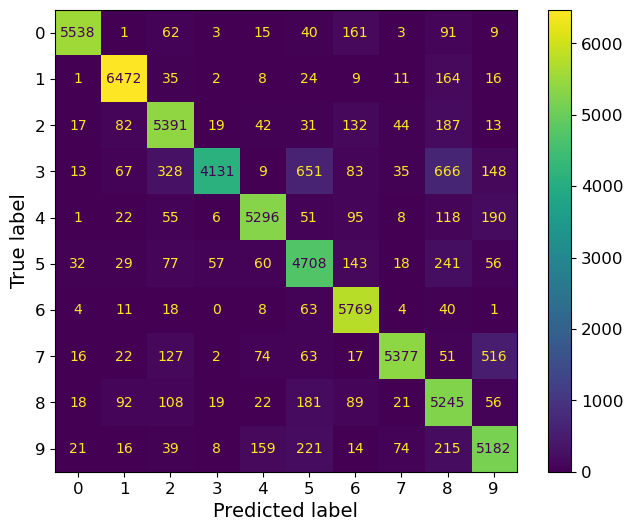

In [60]:
#confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_train,y_hat,values_format='.5g') 

#### Making a pipeline

In [61]:
estimators = [('std_scaler',MinMaxScaler()),('bin_clf',Perceptron())]
pipe = Pipeline(estimators)

In [62]:
pipe.fit(X_train,y_train_0)

Pipeline(steps=[('std_scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

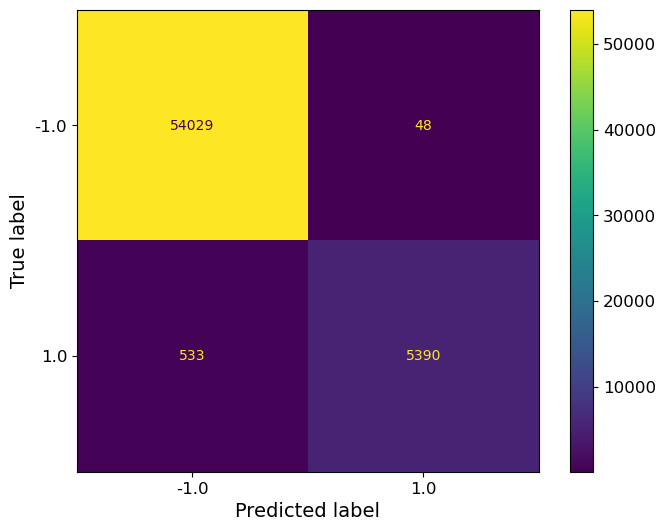

In [64]:
y_hat_train_0 = pipe.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0,y_hat_train_0,values_format='.5g') 
plt.show()

### Iteration vs loss curve

In [66]:
iterations = 100
bin_clf1 = Perceptron(max_iter=1000,random_state=2094)
Loss_clf1 = []
for i in range(iterations):
  bin_clf1.partial_fit(X_train,y_train_0,classes=np.array([1,-1]))
  y_hat_0 = bin_clf1.decision_function(X_train)
  Loss_clf1.append(hinge_loss(y_train_0,y_hat_0))

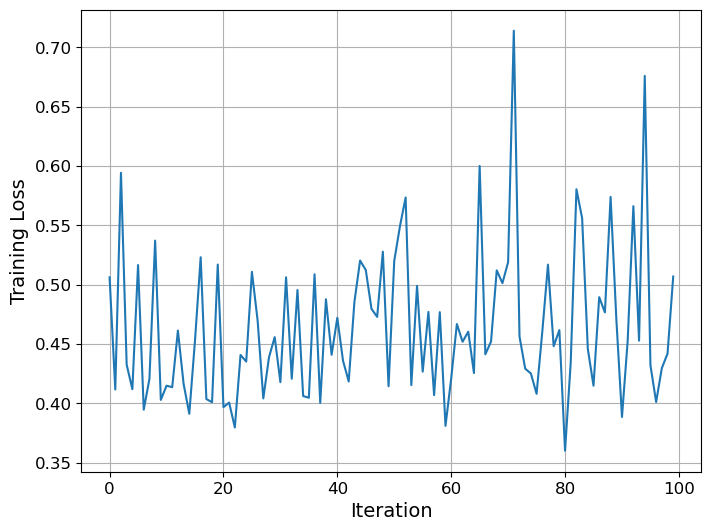

In [67]:
plt.figure()
plt.plot(np.arange(iterations),Loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()